In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
#import jax
#jax.config.update('jax_platform_name', 'cpu')

In [1]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.models import NoiseOutsourcingModel, KantorovichGapModel
from entot.models.utils import MixtureNormalSampler
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import scanpy as sc

In [2]:
adata = sc.read("../../../../data/adata_pancreas_2022_processed_new.h5ad")

In [3]:
sc.pp.pca(adata, n_comps=10)

In [4]:
source = adata[adata.obs["sample"]=="E14.5"].obsm["X_pca"].copy()
target = adata[adata.obs["sample"]=="E15.5"].obsm["X_pca"].copy()

In [6]:
kg = KantorovichGapModel(epsilon=0.1, input_dim=[10], iterations=3000)

In [7]:
kg(source, target)

100%|██████████| 3000/3000 [32:49<00:00,  1.52it/s]


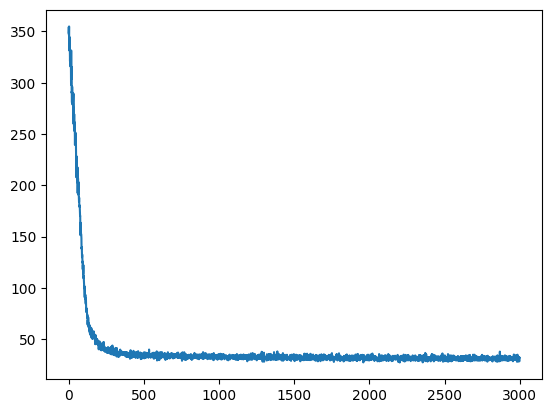

In [8]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["total_loss"])

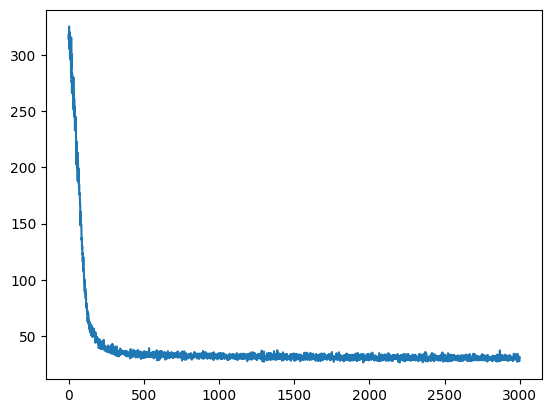

In [9]:
plt.plot(np.arange(len(kg.metrics["fitting_loss"])), kg.metrics["fitting_loss"])

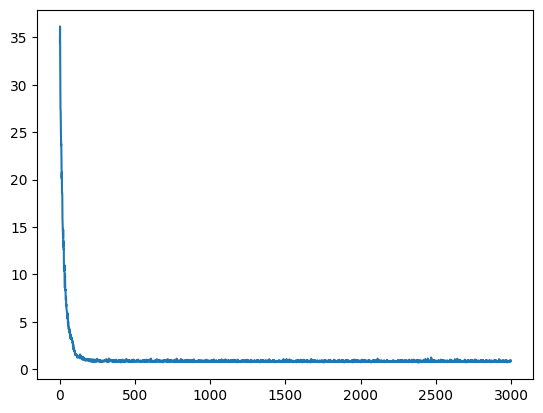

In [10]:
plt.plot(np.arange(len(kg.metrics["total_loss"])), kg.metrics["kant_gap"])

In [11]:
noise = jax.random.normal(jax.random.PRNGKey(0), shape=(len(source), 4))

In [12]:
source_with_noise = jnp.concatenate((source, noise), axis=1)

In [13]:
pushed = kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)

In [14]:
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((pushed, target), axis=0)

In [15]:
del bdata.uns
del bdata.obsp

In [16]:
bdata.obsm

AxisArrays with keys: X_pca, X_pca_wsnn, X_spca_wsnn, X_umap, X_umap_ATAC, X_umap_GEX, X_umap_wsnn, lsi_full, lsi_red, umap, umap_ATAC, umap_GEX, X_pca_result

In [17]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/umap/d

In [18]:
sc.tl.umap(bdata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


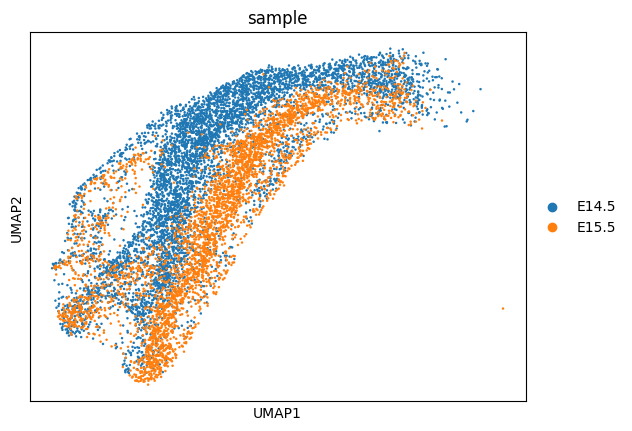

In [19]:
sc.pl.umap(bdata, color="sample")

In [49]:
adata.obsm["X_pca_original"] = np.concatenate((source, target), axis=0)


In [50]:
sc.pp.neighbors(adata, use_rep="X_pca_original")

In [51]:
sc.tl.umap(adata)

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


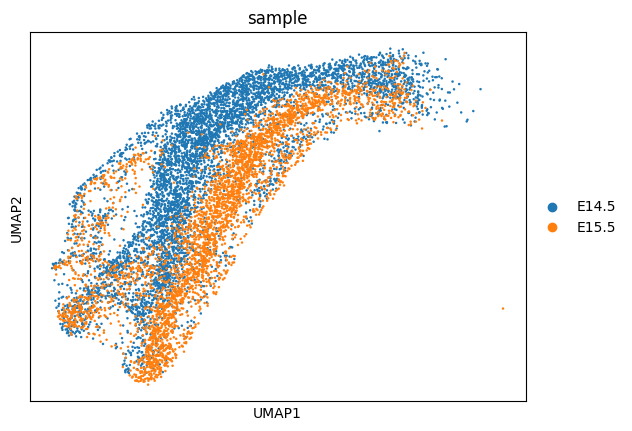

In [53]:
sc.pl.umap(adata, color="sample")

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


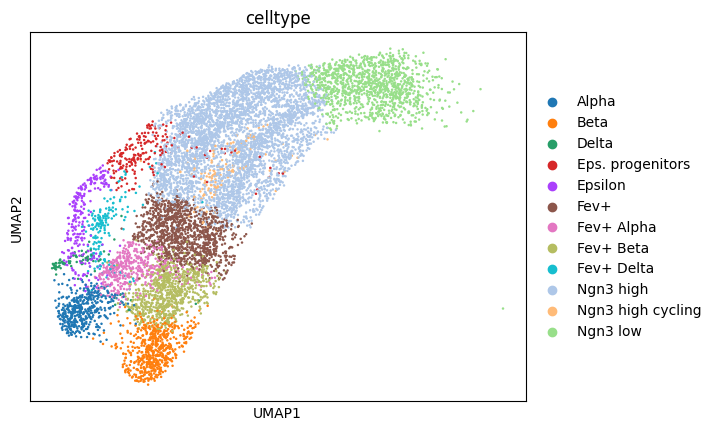

In [54]:
sc.pl.umap(adata, color="celltype")

In [55]:
res = [None] * 15

for i in range(15):
    noise = jax.random.normal(jax.random.PRNGKey(i), shape=(len(source), 4))
    source_with_noise = jnp.concatenate((source, noise), axis=1)
    res[i]= kg.state_neural_net.apply_fn({"params": kg.state_neural_net.params}, source_with_noise)


In [56]:
samples = jnp.array(res)

In [57]:
samples.shape

(15, 5539, 10)

In [58]:
vars = jnp.var(samples, axis=0)

In [59]:
vars_summed = jnp.sum(vars, axis=1)

In [60]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
bdata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

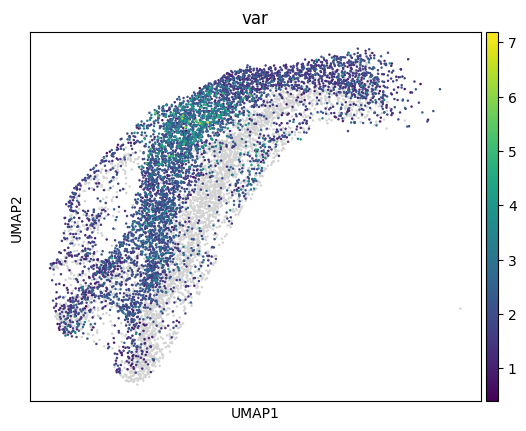

In [61]:
sc.pl.umap(bdata, color="var")

In [62]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Alpha,1.701161
Beta,1.512374
Delta,1.400051
Eps. progenitors,1.872609
Epsilon,1.570571
Fev+,2.026311
Fev+ Alpha,1.760879
Fev+ Beta,1.885538
Fev+ Delta,1.734424
